In [20]:
import torch
import numpy as np

# Atrifical neurons

Equation: 
$$
o = \tanh(wx+b)
$$
Where

- $o$ - Output (vector or scalar)
- $\tanh$ - Nonlinear activation function
- $w$ - Weight (matrix or scalar)
- $x$ - Input (vector or scalar)
- $b$ - Bias (vector or scalar)

The weight and bias are the learned parameters

functions like $tanh$ and a sigmoid are good, since they are sensitive to in-between values, and lump very high scores together near 1, and very low scores together near 0 or -1

Activation functions are nonlinear, and should be differentiable (with a finite number of point discontinuities, like ReLU or Hardtanh)

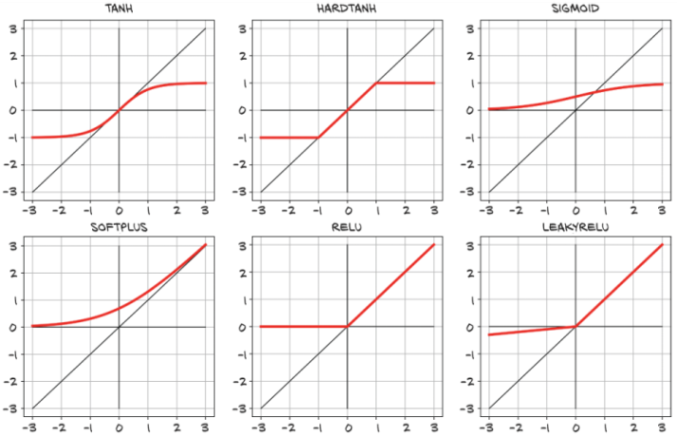

Backpropagation also relies on gradients, so errors will propagate more effectively when the inputs are in the response range of the neuron

In [21]:
t_c = [0.5,  14.0, 15.0, 28.0, 11.0,  8.0,  3.0, -4.0,  6.0, 13.0, 21.0]
t_u = [35.7, 55.9, 58.2, 81.9, 56.3, 48.9, 33.9, 21.8, 48.4, 60.4, 68.4]
t_c = torch.tensor(t_c).unsqueeze(1)
t_u = torch.tensor(t_u).unsqueeze(1)

t_u.shape # batch size is 11:

torch.Size([11, 1])

In [22]:

n_samples = t_u.shape[0]
n_val = int(0.2 * n_samples)

shuffled_indices = torch.randperm(n_samples)

train_indices = shuffled_indices[:-n_val]
val_indices = shuffled_indices[-n_val:]

t_u_train = t_u[train_indices]
t_c_train = t_c[train_indices]

t_u_val = t_u[val_indices]
t_c_val = t_c[val_indices]

t_un_train = 0.1 * t_u_train
t_un_val = 0.1 * t_u_val

In [23]:
import torch.nn as nn

linear_model = nn.Linear(1, 1) # input features, output features
linear_model(t_un_val) # used instead of linear_model.forward

tensor([[4.2156],
        [4.3663]], grad_fn=<AddmmBackward0>)

In [24]:
linear_model.weight

Parameter containing:
tensor([[0.7929]], requires_grad=True)

In [25]:
linear_model.bias

Parameter containing:
tensor([-0.2487], requires_grad=True)

## Batching

PyTorch expects input tensors of shape (batch size, # of input features). This is performed above for the temperature data

In [26]:
x = torch.ones(10,1)
linear_model(x)

tensor([[0.5443],
        [0.5443],
        [0.5443],
        [0.5443],
        [0.5443],
        [0.5443],
        [0.5443],
        [0.5443],
        [0.5443],
        [0.5443]], grad_fn=<AddmmBackward0>)

## Training

In [27]:
import torch.optim as optim

linear_model = nn.Linear(1,1)

optimizer = optim.SGD(
    linear_model.parameters(),
    lr = 1e-2
)

In [32]:
def training_loop(n_epochs, optimizer, model, loss_fn, t_u_train, t_u_val,
                  t_c_train, t_c_val):
    
    for epoch in range(n_epochs):
        t_p_train = model(t_u_train)
        loss_train = loss_fn(t_p_train, t_c_train)

        t_p_val = model(t_u_val)
        loss_val = loss_fn(t_p_val, t_c_val)

        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}, Training loss {loss_train.item():.4f},"
                  f" Validation loss {loss_val.item():.4f}")

In [33]:
linear_model = nn.Linear(1,1)
optimizer = optim.SGD(linear_model.parameters(), lr = 1e-2)

training_loop(
    n_epochs=3000,
    optimizer=optimizer,
    model=linear_model,
    loss_fn=nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val
)

print(linear_model.weight)
print(linear_model.bias)

Epoch 0, Training loss 163.0757, Validation loss 145.4953
Epoch 1000, Training loss 3.5079, Validation loss 2.5707
Epoch 2000, Training loss 3.0428, Validation loss 2.5042
Parameter containing:
tensor([[5.3721]], requires_grad=True)
Parameter containing:
tensor([-17.2292], requires_grad=True)


# Neural Network

We now build a simple neural network with an input, a hidden layer of 13 tanh nodes, and then a linear node to recombine these

In [34]:
n_tanh = 13

seq_model = nn.Sequential(
    nn.Linear(1, n_tanh),
    nn.Tanh(),
    nn.Linear(n_tanh, 1)
)

seq_model

Sequential(
  (0): Linear(in_features=1, out_features=13, bias=True)
  (1): Tanh()
  (2): Linear(in_features=13, out_features=1, bias=True)
)

In [35]:
[param.shape for param in seq_model.parameters()]

[torch.Size([13, 1]), torch.Size([13]), torch.Size([1, 13]), torch.Size([1])]

We can also have named layers, using an `OrderedDict`:

In [36]:
from collections import OrderedDict

seq_model = nn.Sequential(OrderedDict([
    ('hidden_linear', nn.Linear(1, 8)),
    ('hidden_activation', nn.Tanh()),
    ('output_linear', nn.Linear(8, 1))
]))
 
seq_model

Sequential(
  (hidden_linear): Linear(in_features=1, out_features=8, bias=True)
  (hidden_activation): Tanh()
  (output_linear): Linear(in_features=8, out_features=1, bias=True)
)

In [37]:
for name, param in seq_model.named_parameters():
    print(name, param.shape)

hidden_linear.weight torch.Size([8, 1])
hidden_linear.bias torch.Size([8])
output_linear.weight torch.Size([1, 8])
output_linear.bias torch.Size([1])


We can now actually train it:

In [38]:
optimizer = optim.SGD(seq_model.parameters(), lr=1e-3)

training_loop(
    n_epochs = 5000,
    optimizer = optimizer,
    model = seq_model,
    loss_fn = nn.MSELoss(),
    t_u_train = t_un_train,
    t_u_val = t_un_val,
    t_c_train = t_c_train,
    t_c_val = t_c_val)
 
print('output', seq_model(t_un_val))
print('answer', t_c_val)
print('hidden', seq_model.hidden_linear.weight.grad)

Epoch 0, Training loss 194.2106, Validation loss 177.0322
Epoch 1000, Training loss 5.3209, Validation loss 2.7905
Epoch 2000, Training loss 3.2410, Validation loss 2.5843
Epoch 3000, Training loss 2.3277, Validation loss 2.6476
Epoch 4000, Training loss 1.9011, Validation loss 2.3033
output tensor([[11.8744],
        [13.1764]], grad_fn=<AddmmBackward0>)
answer tensor([[11.],
        [15.]])
hidden tensor([[-4.4685],
        [-0.2046],
        [-4.6064],
        [-4.2260],
        [ 0.0712],
        [ 4.5365],
        [ 0.1480],
        [ 0.0778]])
